# Forecasting by LSTM Prediction

# Test Data Preparation

The transformed ping train dataset from 01_data_preparation_driver_hours_prediction_LSTM_with_auxillary_input is loaded and merged to the test data ping dataset. The test ping dataset is first processed similar to the train dataset. First transaction information is converted to long format individual records from pings.csv by driver ID. Online hours are computed by counting the number of pings on any given day. Drivers without any ping data on a day are assumed to be offline on that day i.e. 0 hours online.

In [105]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

import pandas as pd
import os
import datetime
import numpy as np

from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
# data prep helper functions
def read_csv(path, sep=",", sortby=[]):
    '''
    read csv files
    '''
    # load data
    data = pd.read_csv(path, sep=sep)
    
    # sort and reindex
    data = data.sort_values(sortby, ascending=False)
    data = data.reset_index(drop=True)
    
    print("Data loading & sorting completed")
    print("Total Observation: ", data.shape[0])
    return data

def check_data(data):
    '''
    check data for duplicates and missing values
    '''
    # Drop duplicates
    initial_nrow = data.shape[0]
    data.drop_duplicates()
    post_nrow = data.shape[0]
    print("Total duplicates dropped: ", initial_nrow - post_nrow)
    
    # Empty columns - Find NaN counts per columns
    null_columns = data.columns[data.isnull().any()]
    if len(null_columns)==0:
        print("No missing values")
    else:
        print("Missing values found in: ", null_columns)
        print("Missing counts in missing columns: ", data[null_columns].isnull().sum())


def prep_test_ping_data(data, uni_id, uni_dt):
    '''
    create dataset for online hours per day per driver. Modifications are made to prep_ping_data()
    '''
    driver_ping_summary = []

    id_counter = 0
    total_id = len(uni_id)
    days = len(uni_dt)
    
    for ID in uni_id:
        id_counter += 1
        tmp = data[data['driver_id'] == ID]
        day_counter = days + 1
        for dt in uni_dt:
            day_counter -= 1
            tmp_dt = tmp[tmp['ping_date'] == dt]
            if tmp_dt.shape[0] > 0:
                online_hr = int(tmp_dt['online_hrs'].values[0])
                if tmp_dt.shape[0] > 1:
                    print('{}....Check ID'.format(ID))
            else:
                 online_hr = 0 #assume 0 hrs driven if no pings
            driver_ping_summary.append({'driver_id':ID, 'date': dt ,'online_hrs': online_hr, 'day_count': day_counter})
        if id_counter % 249 == 0:
            print(("Completed driver {}/{}").format(id_counter, total_id))
    return pd.DataFrame(driver_ping_summary)

In [4]:
# define data folder path
CWD = os.getcwd()
DATA = CWD + "\\data\\"

## Train Ping Data

Load the train ping data tranformed from 01_data_preparation_driver_hours_prediction_LSTM_with_auxillary_input

In [5]:
# load train data
piv_driver_ping_summary = read_csv(DATA+"merged_driver_and_ping_data.csv", sortby=['driver_id'])
piv_driver_ping_summary = piv_driver_ping_summary.drop(["Unnamed: 0"], axis=1)
piv_driver_ping_summary.set_index("driver_id", inplace=True)
piv_driver_ping_summary.head()

Data loading & sorting completed
Total Observation:  2483


,2017-06-01,2017-06-02,2017-06-03,2017-06-04,2017-06-05,2017-06-06,2017-06-07,2017-06-08,2017-06-09,2017-06-10,...,2017-06-17,2017-06-18,2017-06-19,2017-06-20,2017-06-21,gender,age,number_of_kids,isMALE,hasKids
driver_id,,,,,,,,,,,,,,,,,,,,,
998229,7,5,4,5,7,7,7,7,7,7,...,4,5,7,0,7,MALE,31,0,1,0
998215,4,5,0,0,5,5,0,3,6,0,...,0,0,6,5,4,FEMALE,52,2,0,1
997510,5,7,4,4,3,5,6,4,5,4,...,6,3,4,4,3,MALE,61,3,1,1
997500,7,4,5,0,4,3,5,6,3,7,...,6,0,4,5,6,MALE,54,1,1,1
997190,2,2,2,1,3,0,4,0,2,1,...,1,1,1,1,1,FEMALE,20,0,0,0


## Test Ping Data

Prepare test data 

In [9]:
# Load test data and reindex
test_data = read_csv(DATA+"test.csv", sortby=['driver_id'])

Data loading & sorting completed
Total Observation:  17500


In [10]:
# Check test pings data for duplicates and missing values
check_data(test_data)

Total duplicates dropped:  0
No missing values


In [11]:
# Convert Date
test_data = test_data.rename({'date':'ping_date', 'online_hours':'online_hrs'}, axis=1)
test_data['ping_date'] = pd.to_datetime(test_data['ping_date'])
test_data['ping_date'] = test_data['ping_date'].dt.tz_localize('Asia/Jakarta')
test_data['ping_date']= test_data['ping_date'].dt.date

In [12]:
# remove three drivers - some exploration lead to the repetition discovery 
# e.g. same date with two different online_hrs values [800600, 799250, 320227]
test_data = test_data[~(test_data.driver_id.isin([800600, 799250, 320227]))]

In [13]:
# Determine time online per driver per day
uni_drive_id_test = test_data['driver_id'].unique()
uni_ping_dt_test =  test_data['ping_date'].unique()

In [14]:
# create dataset for online hours per day per driver
driver_ping_summary_test = prep_test_ping_data(test_data, uni_drive_id_test, uni_ping_dt_test)

Completed driver 86/2494
Completed driver 172/2494
Completed driver 258/2494
Completed driver 344/2494
Completed driver 430/2494
Completed driver 516/2494
Completed driver 602/2494
Completed driver 688/2494
Completed driver 774/2494
Completed driver 860/2494
Completed driver 946/2494
Completed driver 1032/2494
Completed driver 1118/2494
Completed driver 1204/2494
Completed driver 1290/2494
Completed driver 1376/2494
Completed driver 1462/2494
Completed driver 1548/2494
Completed driver 1634/2494
Completed driver 1720/2494
Completed driver 1806/2494
Completed driver 1892/2494
Completed driver 1978/2494
Completed driver 2064/2494
Completed driver 2150/2494
Completed driver 2236/2494
Completed driver 2322/2494
Completed driver 2408/2494
Completed driver 2494/2494


In [15]:
# pivot data - each row is one driver
piv_driver_ping_summary_test = driver_ping_summary_test.pivot_table(values='online_hrs', index='driver_id', columns='date')

In [16]:
# check pivoted data
piv_driver_ping_summary_test[0:5]

date,2017-06-22,2017-06-23,2017-06-24,2017-06-25,2017-06-26,2017-06-27,2017-06-28
driver_id,,,,,,,
111556,2,5,0,0,0,3,3
111575,9,0,0,0,9,6,0
111779,2,5,0,0,0,2,4
111839,8,8,9,10,9,8,10
112486,1,2,0,0,5,1,4


## Merge Train and Test Ping Data

In [34]:
# merge piv_driver_ping_summary and driver_ping_summary_test
merged_data_with_test = pd.merge(piv_driver_ping_summary, piv_driver_ping_summary_test, how='inner', on=['driver_id'])

# reorder rows
merged_data_with_test = pd.concat([merged_data_with_test.iloc[:,0:21], merged_data_with_test.iloc[:,26:], merged_data_with_test.iloc[:,21:26]], axis=1)

# select relevant dataframe from 2017-06-15 to 'number of kids'
merged_data_with_test = merged_data_with_test.iloc[:,14:]

# Show sample
print(merged_data_with_test.shape)
merged_data_with_test[0:5]

(2477, 19)


,2017-06-15,2017-06-16,2017-06-17,2017-06-18,2017-06-19,2017-06-20,2017-06-21,2017-06-22,2017-06-23,2017-06-24,2017-06-25,2017-06-26,2017-06-27,2017-06-28,gender,age,number_of_kids,isMALE,hasKids
driver_id,,,,,,,,,,,,,,,,,,,
998229,5,6,4,5,7,0,7,8,6,9,5,5,5,5,MALE,31,0,1,0
998215,5,5,0,0,6,5,4,7,7,0,0,6,6,4,FEMALE,52,2,0,1
997510,0,7,6,3,4,4,3,6,6,7,5,5,5,5,MALE,61,3,1,1
997500,6,5,6,0,4,5,6,5,7,5,0,7,6,5,MALE,54,1,1,1
997190,0,2,1,1,1,1,1,4,1,0,4,3,3,3,FEMALE,20,0,0,0


## Sequence Merged Data
Create multiple sequences for merged ping and driver data

In [29]:
def strided_app(a, L, S, index, tstart, tend, auxstart, auxend):  
    '''
    creates a strided dataset for each driver
    Modified from https://stackoverflow.com/questions/40084931/taking-subarrays-from-numpy-array-with-given-stride-stepsize
    Window len = L, Stride len/stepsize = S
    tstart, tend = start and end column time features
    auxstart, auxend = start and end column auxillary features
    '''
    a_main = a.iloc[tstart:tend]
    nrows = ((a_main.size-L)//S)+1
    n = a_main.strides[0]
    a_new = np.lib.stride_tricks.as_strided(a, shape=(nrows,L), strides=(S*n,n))
    
    other_vars = np.tile(a[auxstart:auxend], (nrows,1))
    a_new_all = np.zeros((nrows, L+(auxend-auxstart)))
    
    
    a_new_all[:,0:L] = a_new
    a_new_all[:,L:] = other_vars
    a_new_all = pd.DataFrame(a_new_all)
    a_new_all = a_new_all.set_index(index.repeat(nrows))
    return a_new_all


def prepare_lstm_data(data, window, stride, tstart, tend, auxstart, auxend):
    '''
    convert the data for lstm
    '''
    ind = data.index
    transformed_data = pd.DataFrame()
    for j in range(len(data)):
        transformed_data = transformed_data.append(strided_app(data.iloc[j], window, stride, ind[j], tstart, tend, auxstart, auxend))
    transformed_data.columns = ["day_{}".format(i) for i in range(0,window)] + ["age", "number_of_kids", "isMALE"]
    return transformed_data


In [30]:
# Define LSTM data preparation parameters
t_start, t_end = 0, 14
aux_start, aux_end = 14, 17
window = 8
stride = 1

In [35]:
# reindex data and drop columns
# index_merged_data_test = merged_data_with_test.set_index(['driver_id'])
index_merged_data_test = merged_data_with_test.drop(['gender', 'hasKids'], axis=1)

# prepare data for scoring
transformed_data_test = prepare_lstm_data(index_merged_data_test, window, stride, t_start, t_end, aux_start, aux_end)

c:\users\julian.addison\appdata\local\continuum\anaconda3\envs\gpu_env\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Series.strides is deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()


In [36]:
"Original data: {} was modified to {}".format(index_merged_data_test.shape, transformed_data_test.shape)

'Original data: (2477, 17) was modified to (17339, 11)'

In [37]:
transformed_data_test[0:5]

,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,age,number_of_kids,isMALE
998229,5.0,6.0,4.0,5.0,7.0,0.0,7.0,8.0,31.0,0.0,1.0
998229,6.0,4.0,5.0,7.0,0.0,7.0,8.0,6.0,31.0,0.0,1.0
998229,4.0,5.0,7.0,0.0,7.0,8.0,6.0,9.0,31.0,0.0,1.0
998229,5.0,7.0,0.0,7.0,8.0,6.0,9.0,5.0,31.0,0.0,1.0
998229,7.0,0.0,7.0,8.0,6.0,9.0,5.0,5.0,31.0,0.0,1.0


In [38]:
# check and save test csv
transformed_data_test.to_csv(DATA+"merged_driver_and_ping_data_test.csv", index=True)

# Prediction

In [39]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense, LSTM, concatenate
from keras.optimizers import SGD, Adam
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [40]:
# model helper functions
def eval_rmse(target, pred):
    '''
    RMSE for models
    '''
    rmse = sqrt(mean_squared_error(target, pred))
    print('Test RMSE: %.3f' % rmse)
    return rmse


def predict_model(test, test_y, yhat):
    '''
    predict on test data
    '''
    test = test.reshape((test.shape[0], test.shape[2]))
    
    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test[:, 1:]), axis=1)
    #inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test[:, 1:]), axis=1)
    #inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
    return inv_y, inv_yhat

def predict_model_aux(test_temporal, test_aux, test_y, yhat):
    '''
    predict on test data
    '''
    test_temporal = test_temporal.reshape((test_temporal.shape[0], test_temporal.shape[2]))
    
    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_temporal[:, 1:], test_aux[:, test_temporal.shape[1]+1:]), axis=1)
    #inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]

    # invert scaling for actual
#     test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_temporal[:, 1:], test_aux[:, test_temporal.shape[1]+1:]), axis=1)
    #inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
    return inv_y, inv_yhat

## LSTM Model Scoring
This model will serve as the base model for comparison with the auxillary input model. Only the time series elements are used. For simplicity a single LSTM layer is used. 

In [45]:
from keras.models import load_model

In [41]:
# Load Trained model
def loading_model(model_path, model_weights_path):
    model = load_model(model_path)
    model.load_weights(model_weights_path)
    return model

In [166]:
# define model location
MODEL_PATH = CWD + "\\model\\run1_2019-08-23model.h5"
MODEL_WEIGHTS_PATH = CWD + "\\model\\run1_2019-08-23model_weights.h5"

In [167]:
# select temporal features, target and reshape data
transformed_data_temporal_pred_test = transformed_data_test[['day_7']].values

transformed_data_temporal_test = transformed_data_test.drop(["day_7", "age", "number_of_kids", "isMALE"], axis=1)
transformed_data_temporal_test = transformed_data_temporal_test.values
transformed_data_temporal_test = transformed_data_temporal_test.reshape((transformed_data_temporal_test.shape[0],
                                                                         1, transformed_data_temporal_test.shape[1]))

In [168]:
# load model
model = loading_model(MODEL_PATH, MODEL_WEIGHTS_PATH)

In [169]:
# predict
yhat_base = model.predict(transformed_data_temporal_test)
inv_y_base, inv_yhat_base = predict_model(transformed_data_temporal_test, transformed_data_temporal_pred_test, yhat)

# calculate RMSE
rmse = eval_rmse(inv_y_base, inv_yhat_base)

Test RMSE: 2.106


## LSTM Model Scoring with Auxillary Inputs
Conceptually, the following approach is taken to add auxillary data into the model. 


TIME_SERIES_INPUT ------> LSTM -------\

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;---> MERGE ---> [more processing]

AUXILIARY_INPUTS --> [do something] --/

In [170]:
# define model location
MODEL_AUX_PATH = CWD + "\\model\\run1_2019-08-23model_aux.h5"
MODEL_AUX_WEIGHTS_PATH = CWD + "\\model\\run1_2019-08-23model_aux_weights.h5"

In [171]:
# load model
model_aux = loading_model(MODEL_AUX_PATH, MODEL_AUX_WEIGHTS_PATH)

In [172]:
# Prepare auxillary data
transformed_data_aux_test = transformed_data_test[["age", "number_of_kids", "isMALE"]]
transformed_data_aux_test = transformed_data_aux_test.values
transformed_data_aux_test = transformed_data_aux_test.reshape((transformed_data_aux_test.shape[0], transformed_data_aux_test.shape[1]))

In [173]:
# predict
yhat_aux = model_aux.predict({'temporal_input':transformed_data_temporal_test, 'auxillary_input':transformed_data_aux_test})
inv_y_aux, inv_yhat_aux = predict_model_aux(transformed_data_temporal_test, transformed_data_aux_test,
                                    transformed_data_temporal_pred_test, yhat_aux)

# calculate RMSE
rmse = eval_rmse(inv_y_aux, inv_yhat_aux)

Test RMSE: 2.131


# Compare & Visualise Results

In [183]:
actual = pd.DataFrame(transformed_data_temporal_pred_test.reshape(int(len(transformed_data_test.index.values)/7), 7))
actual['Model'] = 'Actual'
actual['Driver ID'] = transformed_data_test.index.values[0::7]

predicted_base = pd.DataFrame(yhat_base.reshape(int(len(transformed_data_test.index.values)/7), 7))
predicted_base['Model'] = 'LSTM'
predicted_base['Driver ID'] = transformed_data_test.index.values[0::7]

predicted_aux = pd.DataFrame(yhat_aux.reshape(int(len(transformed_data_test.index.values)/7), 7))
predicted_aux['Model'] = 'LSTM with Aux'
predicted_aux['Driver ID'] = transformed_data_test.index.values[0::7]

merged_dataframe = actual.append([predicted_aux, predicted_base])

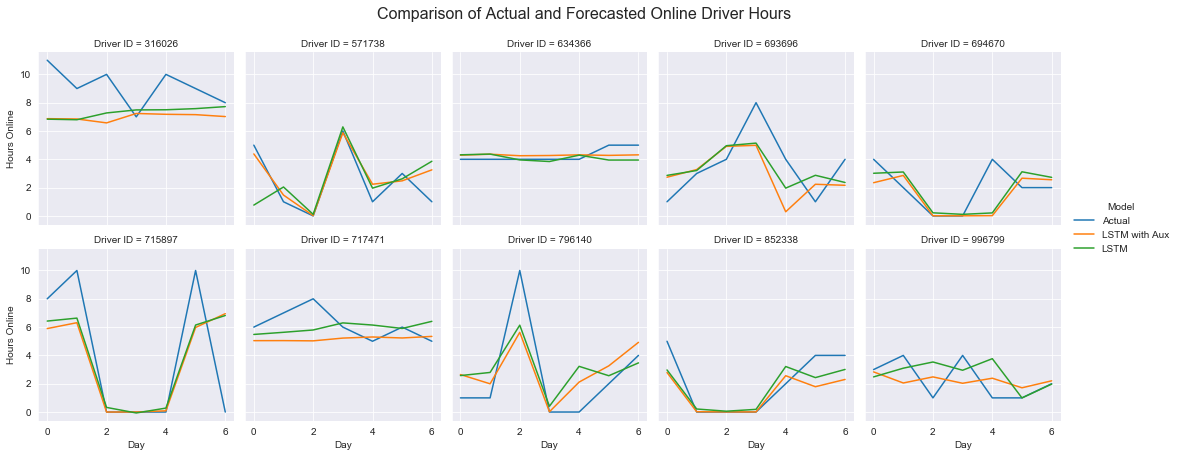

In [200]:
did = np.random.choice(2494, 10, replace=False)
driver_ids = [transformed_data_test.index.values[0::7][i] for i in did] 

tmp = merged_dataframe[merged_dataframe['Driver ID'].isin(driver_ids)]

tmp = pd.melt(tmp, id_vars=['Model', 'Driver ID'], value_vars=[0, 1, 2, 3, 4, 5, 6])
tmp = tmp.rename(columns={'variable': 'Day', 'value': 'Hours Online'})
tmp['Day'] = pd.to_numeric(tmp['Day'], downcast='integer')

g = sns.FacetGrid(tmp, col="Driver ID", hue="Model", col_wrap=5)
g = (g.map(sns.lineplot, "Day", "Hours Online").add_legend())
g = g.fig.suptitle('Comparison of Actual and Forecasted Online Driver Hours', fontsize=16, y=1.05)

#### TODO: create a function to predict hours for specified driver_id